In [2]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [3]:
def data_generator(alpha, b, para_topic, T, N):
    
    mu0, lambda0, W, nu = para_topic
    
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(mu0)
    
    # generate the corpus-level variables
    rho = np.random.dirichlet(alpha, 1)[0]
    a = np.random.exponential(1/b,1)[0]
    
    # generate topics
    s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
    mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])
#     mu = mu*10
    
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu
    
    # generate document
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        tems = np.linalg.inv(np.dot(s2.T, U[i]).reshape(d,d)) # sum_j(u_j * sigma_j^-1), sigma(x) 
        t2 = np.dot(tao.T, U[i]) # sum_j(u_j * tao_j)
        temmu = np.dot(tems, t2) # mu(x)
        tem = np.random.multivariate_normal(temmu, tems)
        X.append(tem)
    X = np.array(X)

    return rho, a, X, Y, U, G, s_inv, mu

In [16]:
# gibbs_g: given T, rho,a and Theta, recover g
def gibbs_gar(X, Y, T, alpha, b, s_inv, mu, G,a,rho, mtime, desired_error):
    '''
    G: ture value of membership score
    mtime: maximum iteration time
    desired_error: desired error of G
    
    output: (G1, arate,error)
    G1: the final estimate
    arate: a list of average accept rate
    error: a list of average estimation error
    '''
    def p1(x, s_inv, mu):
    # return - (x-mu)^T s_inv (x-mu)/2
        return -0.5*np.dot(np.dot((x-mu).T, s_inv), x-mu)
    
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(mu[0])
    N = len(Y)
    
    count = 0 # number of updates
    
    infinity = 2**(-32)
    
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)])
    
    # initialization
    rho1 = np.random.dirichlet(np.ones(dg), 1)[0]
    G1 = np.random.dirichlet(np.ones(dg), N)
    a1 = np.random.exponential(1/b,1)[0]
#     a1=a
    
    errorG, errora, errorrho = [], [], [] # store the error of G, a and rho 
    arateG, aratea, araterho = [], [], [] # store the accept rate of the proposed g
    t = 0
    tem = 1
#     count = 1
    mtime //= 100 
    while t<mtime:
        # if (we get the desired error) or (iteration times > mtime): break
        countG = counta = countrho = 0
        for tt in range(100):
            for i in range(N):
                newg = np.random.dirichlet(a1*rho1, 1)[0] # propose g_i~Dir(a*rho)
                if newg.min()<infinity: continue
                newu = np.dot(T[Y[i]], newg)
                tems_inv = np.dot(s2.T, newu).reshape(d,d)
                tems = np.linalg.inv(tems_inv)
                t2 = np.dot(tao.T, newu)
                temmu = np.dot(tems, t2)
    #             try:
                newp = p1(X[i],tems_inv, temmu) 
    #             except:

                oldg = G1[i]
                if newg.min()<infinity:
                    G1[i] = newg
                    continue
                oldu = np.dot(T[Y[i]], oldg)
                tems_inv = np.dot(s2.T, oldu).reshape(d,d)
                tems = np.linalg.inv(tems_inv)
                t2 = np.dot(tao.T, oldu)
                temmu = np.dot(tems, t2)
                oldp = p1(X[i],tems_inv, temmu) 
                
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                u = np.random.uniform()
                if u < ag:
                    countG += 1
                    G1[i] = newg
            
            newrho = np.random.dirichlet(alpha, 1)[0]
            newp = - N*sc.gammaln(a1*newrho).sum() + ((a1*newrho-1)*np.log(G1)).sum()
            oldp = - N*sc.gammaln(a1*rho1).sum() + ((a1*rho1-1)*np.log(G1)).sum()
            arho = min(1, np.exp(min(1,newp-oldp)))
            u = np.random.uniform()
            if u < arho:
                countrho += 1
                rho1 = newrho
                
            newa = np.random.exponential(1/b,1)[0]
            newp = N*sc.gammaln(newa) - N*sc.gammaln(newa*rho1).sum() + ((newa*rho1-1)*np.log(G1)).sum()
            oldp = N*sc.gammaln(a1) - N*sc.gammaln(a1*rho1).sum() + ((a1*rho1-1)*np.log(G1)).sum()
            aa = min(1, np.exp(min(1,newp-oldp)))
#             print(newp,oldp,"test")
#             aa = 0.5
            if u < aa:
                counta += 1
                a1 = newa
# #                
        araterho.append(countrho/100) 
        errorrho.append(abs(rho1-rho).sum())
        
        aratea.append(counta/100) 
        errora.append(abs(a1-a))
    
        arateG.append(countG/100/N)
        tem = sum(abs(G-G1))/N
        tem = sum(tem)
        errorG.append(tem)
        t += 1

    
    return G1, arateG,errorG, rho1, araterho, errorrho, a1, aratea,errora

In [8]:
def fixT(k0, k1, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):
    dg = k0 + k1 
    ntopic = nlabel*k0+k1
    T = []
    for i in range(nlabel):
        tem = np.block([
            [np.zeros((k0*i,k0+k1))],
            [np.eye(k0), np.zeros((k0, k1))],
            [np.zeros((k0*(nlabel-i-1),k0+k1))],
            [np.zeros((k1,k0)), np.eye(k1)]
        ])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rateG, errorsG, rho_hat, a_raterho, errorsrho, a_hat, a_ratea, errorsa = gibbs_gar(X, Y, T, alpha, b, s_inv, mu, G,a,rho, mtime, desired_error)
#     gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errorsG[-1])
    print("average error of rho is:", errorsrho[-1])
    print("average error of a is:", errorsa[-1])
    print("true rho is:", rho)
    print("estimated rho is:", rho_hat)
    print("true a is:", a)
    print("estimated a is:", a_hat)
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rateG)
        plt.scatter([i*100 for i in range(1, time+1)], errorsG)
        plt.title("estimation error of G")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rateG)
        plt.title("accept rate of G")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsrho)
        plt.title("estimation error of rho")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_raterho)
        plt.title("accept rate of rho")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsa)
        plt.title("estimation error of a")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_ratea)
        plt.title("accept rate of a")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

average error of g is: 0.22204426054731435
average error of rho is: 0.4221160636282394
average error of a is: 0.44085953471206696
true rho is: [0.01955216 0.09430009 0.24697162 0.43882527 0.02483711 0.17334572
 0.00216803]
estimated rho is: [0.06380055 0.11439035 0.17781974 0.3386774  0.08050035 0.13158744
 0.09322417]
true a is: 1.4565938987892915
estimated a is: 1.8974534335013584


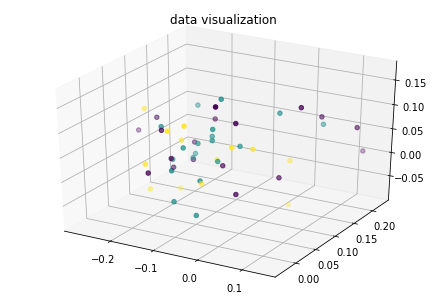

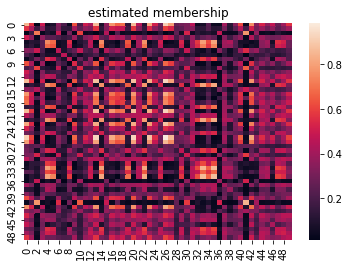

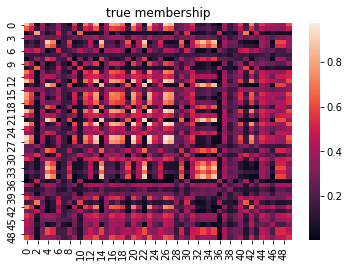

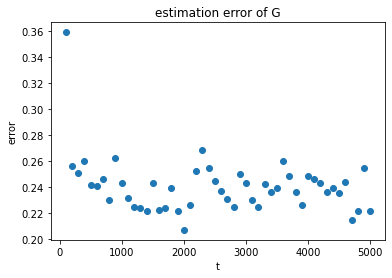

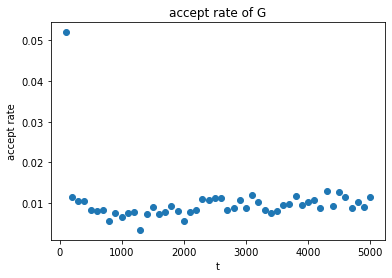

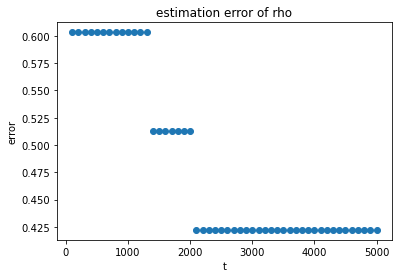

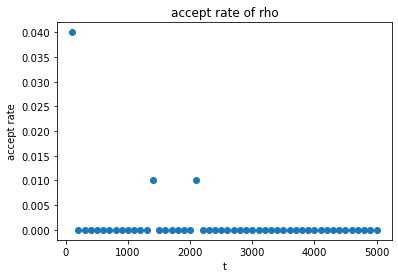

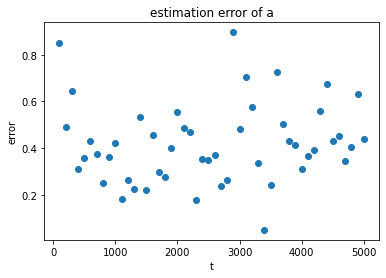

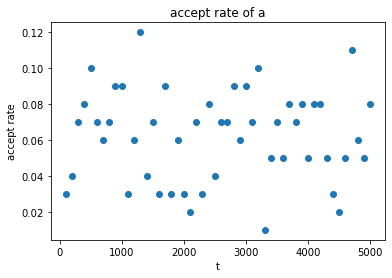

In [18]:
d = 30
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01,1)

average error of g is: 0.05833301542705623
average error of rho is: 0.6141891443144458
average error of a is: 0.9038401039645095
true rho is: [0.15611154 0.27319335 0.41016171 0.05235543 0.02910757 0.02313121
 0.05593918]
estimated rho is: [0.16069412 0.16356747 0.21269302 0.1100874  0.08135793 0.13284853
 0.13875153]
true a is: 0.01551251649242764
estimated a is: 0.9193526204569372


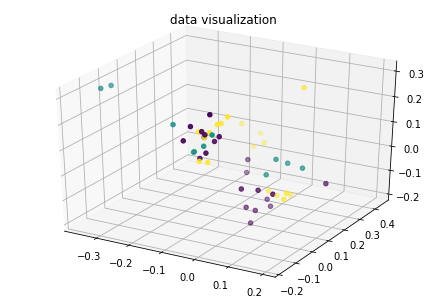

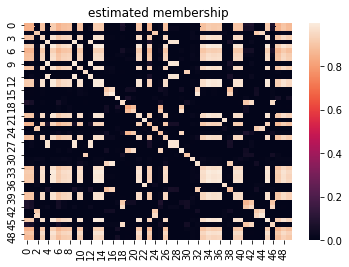

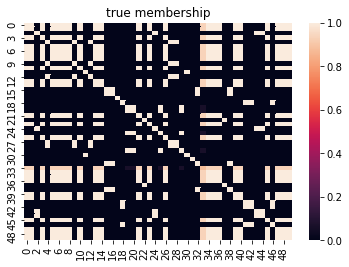

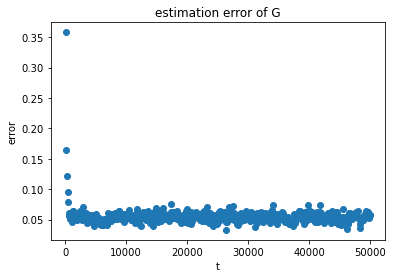

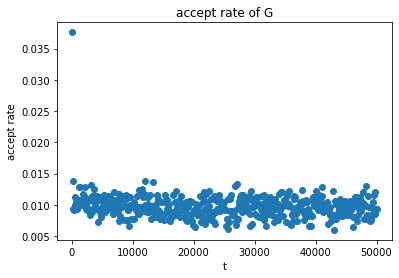

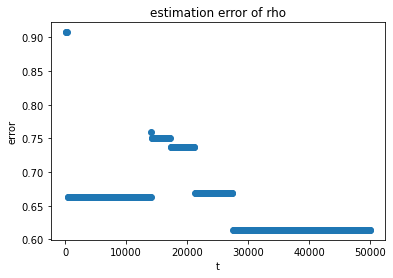

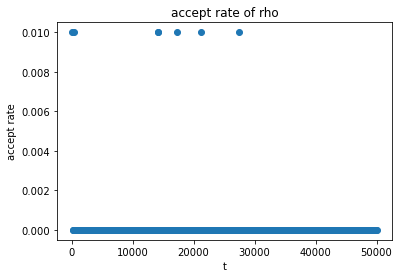

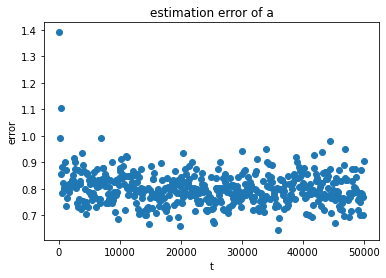

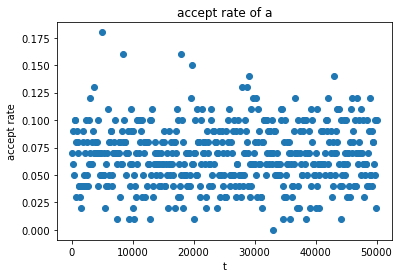

In [19]:
d = 30
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 50000, 0.01,1)

In [20]:
def randomT(dg, ntopic, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):    
    T = []
    for i in range(nlabel):
        tem = np.random.rand(ntopic,dg)
        for j in range(dg):
            tem[:,j] *= 1/sum(tem[:,j])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rateG, errorsG, rho_hat, a_raterho, errorsrho, a_hat, a_ratea, errorsa = gibbs_gar(X, Y, T, alpha, b, s_inv, mu, G,a,rho, mtime, desired_error)
#     gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errorsG[-1])
    print("average error of rho is:", errorsrho[-1])
    print("average error of a is:", errorsa[-1])
    print("true rho is:", rho)
    print("estimated rho is:", rho_hat)
    print("true a is:", a)
    print("estimated a is:", a_hat)
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rateG)
        plt.scatter([i*100 for i in range(1, time+1)], errorsG)
        plt.title("estimation error of G")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rateG)
        plt.title("accept rate of G")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsrho)
        plt.title("estimation error of rho")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_raterho)
        plt.title("accept rate of rho")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsa)
        plt.title("estimation error of a")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_ratea)
        plt.title("accept rate of a")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

average error of g is: 1.1130990396459317
average error of rho is: 0.8743114205690585
average error of a is: 1.6065988782890919
true rho is: [0.04184734 0.05200696 0.18544771 0.08203776 0.48835408 0.01611635
 0.13418979]
estimated rho is: [0.23697715 0.11045914 0.30663841 0.09305094 0.11814596 0.0674862
 0.0672422 ]
true a is: 0.3928629462764452
estimated a is: 1.9994618245655371


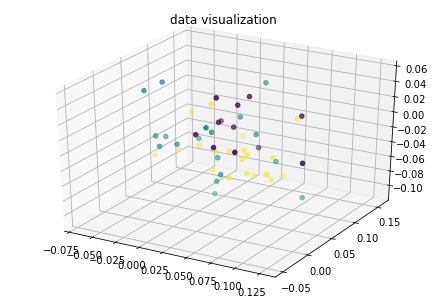

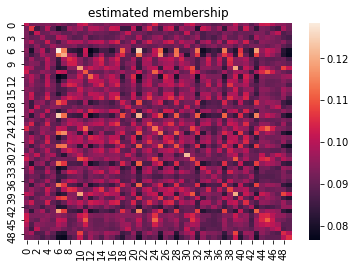

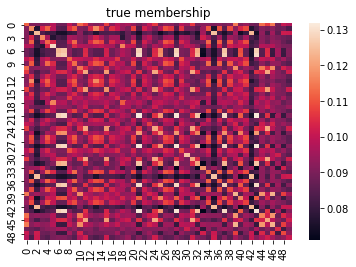

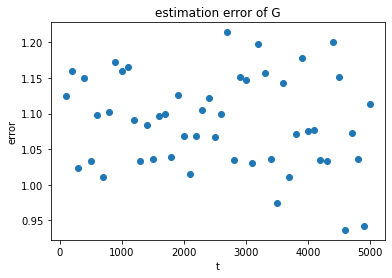

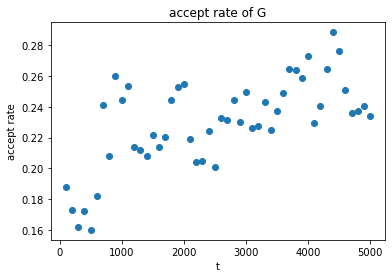

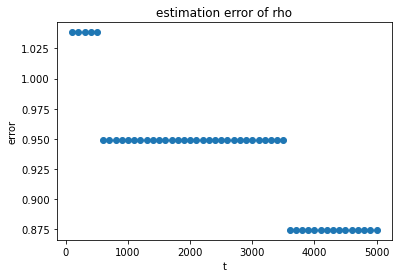

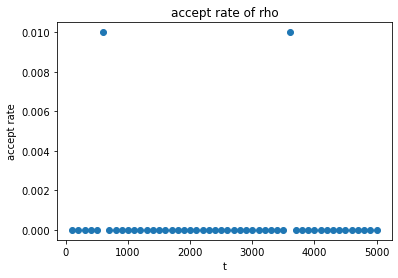

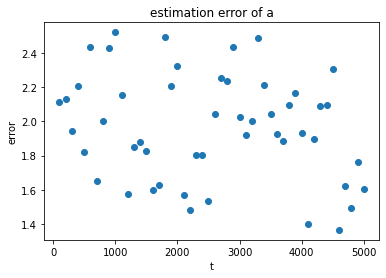

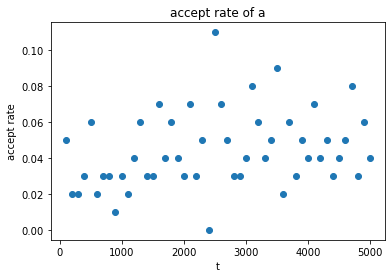

In [21]:
d = 30
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01,1)

average error of g is: 1.1238024816208372
average error of rho is: 0.7530666342713372
average error of a is: 1.6204935809975318
true rho is: [0.06968472 0.01393895 0.11711098 0.3402047  0.06332798 0.31162728
 0.08410538]
estimated rho is: [0.24618003 0.18242397 0.06322821 0.15038807 0.09488098 0.18906306
 0.07383568]
true a is: 1.1470531667577164
estimated a is: 2.7675467477552482


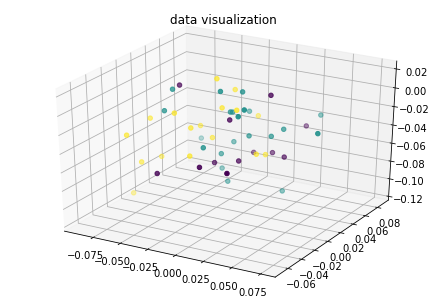

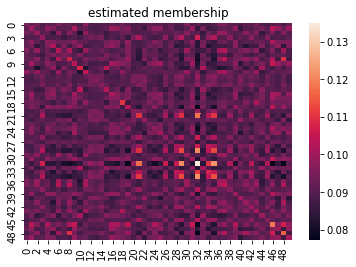

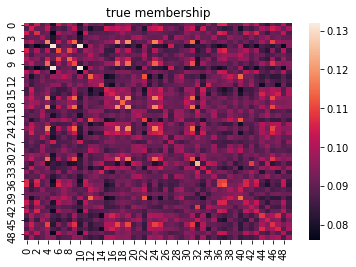

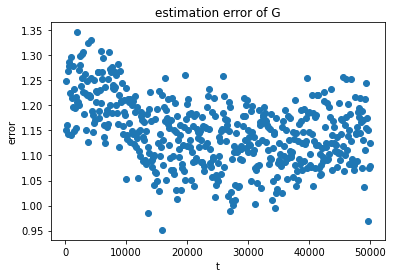

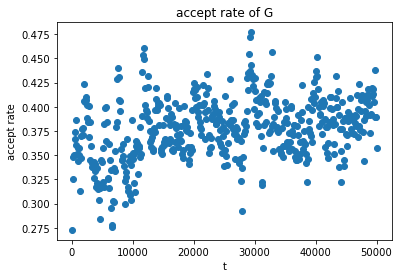

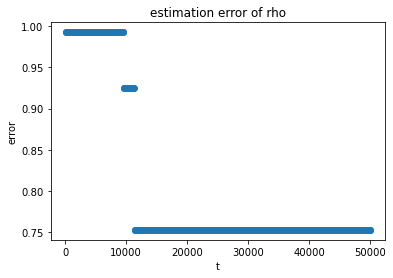

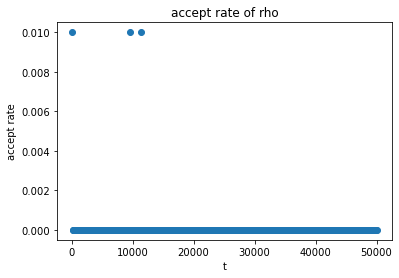

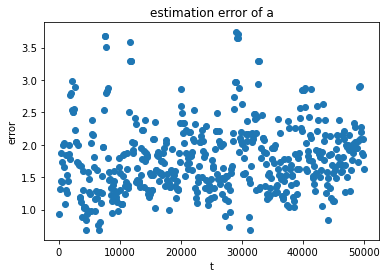

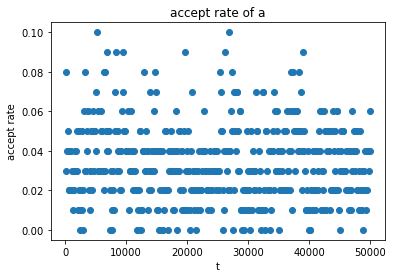

In [22]:
d = 30
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 50000, 0.01,1)

In [25]:
def randomT2(k0, k1, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):
    dg = k0 + k1 
    ntopic = nlabel*k0+k1
    T = []
    for i in range(nlabel):
        tem1 = np.block([
            [np.zeros((k0*i,k0+k1))],
            [np.eye(k0), np.zeros((k0, k1))],
            [np.zeros((k0*(nlabel-i-1),k0+k1))],
            [np.zeros((k1,k0)), np.eye(k1)]
        ])
        tem = np.random.rand(ntopic,dg) + tem1
        for j in range(dg):
            tem[:,j] *= 1/sum(tem[:,j])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rateG, errorsG, rho_hat, a_raterho, errorsrho, a_hat, a_ratea, errorsa = gibbs_gar(X, Y, T, alpha, b, s_inv, mu, G,a,rho, mtime, desired_error)
#     gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errorsG[-1])
    print("average error of rho is:", errorsrho[-1])
    print("average error of a is:", errorsa[-1])
    print("true rho is:", rho)
    print("estimated rho is:", rho_hat)
    print("true a is:", a)
    print("estimated a is:", a_hat)
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rateG)
        plt.scatter([i*100 for i in range(1, time+1)], errorsG)
        plt.title("estimation error of G")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rateG)
        plt.title("accept rate of G")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsrho)
        plt.title("estimation error of rho")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_raterho)
        plt.title("accept rate of rho")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()
        
        plt.scatter([i*100 for i in range(1, time+1)], errorsa)
        plt.title("estimation error of a")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_ratea)
        plt.title("accept rate of a")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

average error of g is: 0.8708935379745185
average error of rho is: 0.7119742418335993
average error of a is: 1.427540416590542
true rho is: [0.26262225 0.04764335 0.30608121 0.05156027 0.08540042 0.0372891
 0.20940341]
estimated rho is: [0.29250351 0.10408042 0.07501884 0.09815579 0.13356546 0.21219732
 0.08447866]
true a is: 0.43513921364707375
estimated a is: 1.8626796302376158


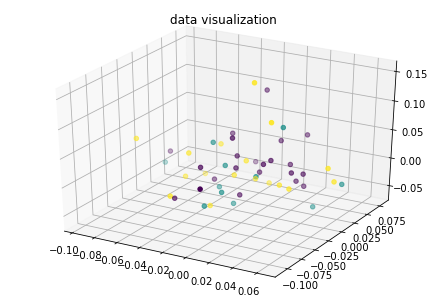

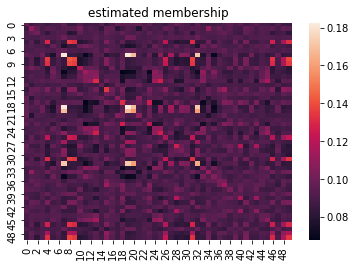

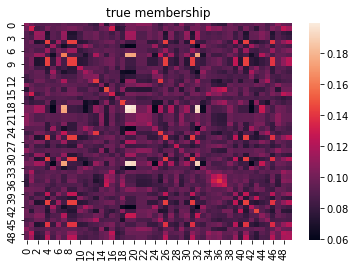

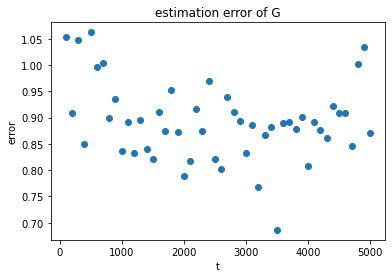

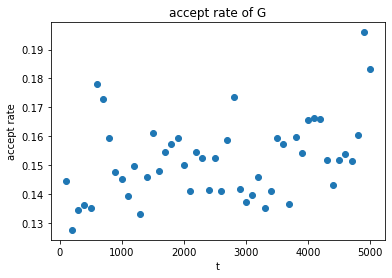

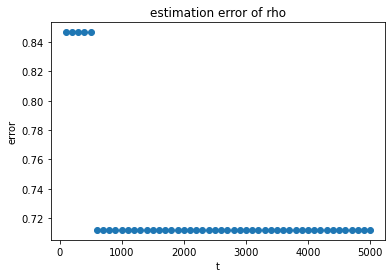

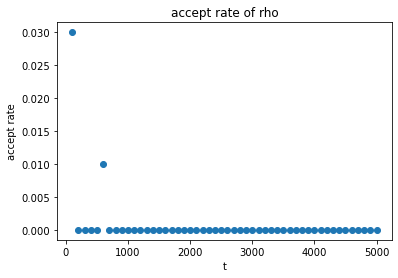

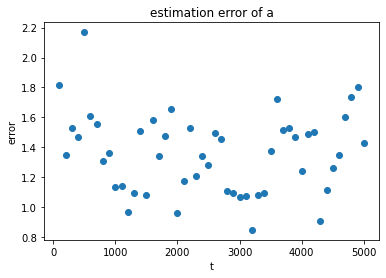

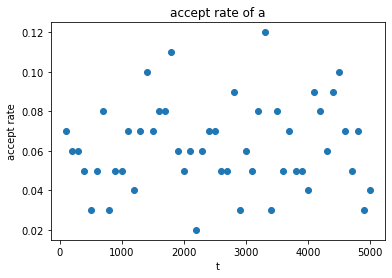

In [26]:
d = 30
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01,1)